Problema relacionado con la gestión ambiental, en este caso con el deterioro de la calidad de los cuerpos de agua y cómo, con el machine learning, se puede apoyar la implementación de mecanismos que permitan monitorear y evaluar las variaciones en las características fisicoquímicas del agua, con el fin de preservar la calidad de estos ecosistemas y garantizar la disponibilidad de agua dulce para la población humana.

#### A. Objetivos.

Aplicar técnicas de clasificación basadas en árboles de decisión y K-vecinos más cercanos para construir modelos predictivos que permitan estimar la calidad del agua de una zona determinada.

Determinar cuáles son los factores que más inciden en la contaminación de los cuerpos de agua con base en los datos.

#### Importacion de Librerias

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

#### Carga de datos
Realizaremos la carga de datos usando la función de Pandas read_csv(), especificando la ruta y el separador del archivo:

In [9]:
data_raw = pd.read_csv('Datos_Etapa-2.csv', sep=',', na_values=['?'], encoding = 'utf-8')

Veamos los primeros datos del conjunto utilizando head():

In [10]:
data_raw.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


No se evidencias variables categoricas

#### Exploración del conjunto de datos
Primero utilizaremos data_raw.describe() para obtener una descripción de las variables numéricas del conjunto de datos

In [11]:
data_raw.describe()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


##### Analisis:

pH: Los valores de pH parecen estar dentro de un rango aceptable para el consumo de agua, pero hay algunos valores cercanos al límite inferior que podrían ser inusuales.

Dureza: La dureza del agua varía ampliamente. Valores más altos podrían estar asociados con problemas de calidad del agua relacionados con minerales.

Sólidos: Hay una amplia gama de sólidos disueltos, y los valores medios y máximos son bastante altos, indicando que algunos cuerpos de agua están muy mineralizados.

Cloraminas: Los niveles de cloraminas parecen estar en un rango relativamente seguro para el agua potable, aunque hay variabilidad.

Sulfatos: Los niveles de sulfatos están bien dentro del rango esperado para el agua potable, aunque los valores altos podrían estar relacionados con la contaminación industrial.

Conductividad: La conductividad eléctrica sugiere una concentración moderada de iones en el agua, con algunos valores elevados que podrían indicar problemas de contaminación.

Carbono Orgánico: Los niveles de carbono orgánico parecen ser relativamente bajos, pero su variabilidad podría influir en la calidad del agua.

Trihalometanos: Los trihalometanos están bastante por debajo del límite máximo recomendado, pero los valores altos pueden ser preocupantes.

Turbidez: La turbidez está bien por debajo del límite recomendado por la OMS, lo cual es positivo.

#### Definición de pasos del preprocesamiento de datos
Primero vamos a definir la variable data para almacenar un conjunto de datos nuevo, utilizando el método copy():

In [12]:
data = data_raw.copy()

Con base al anterior analisis, no veo variables que se puedan eliminar o poco relevantes, por tanto validaramos duplicidad y nulos.

In [13]:
data.duplicated().sum()

np.int64(0)

In [14]:
data.isna().sum()

pH                  491
Dureza                0
Sólidos               0
Cloraminas            0
Sulfatos            781
Conductividad         0
Carbono_orgánico      0
Trihalometanos      162
Turbidez              0
Potabilidad           0
dtype: int64

#### Estandarización de variables numéricas

No se ubicaron duplicados y al realizar el analisis de los nulos, se identifican varios, sin embargo, en vez de eliminar estos datos, realizaremos una imputación para reemplazar los valores nulos por la media, debido a que con base a los datos considero que es la mas apropiada para un buen analisis. En ese sentido, definiremos dos objetos de la clase SimpleImputer(), especificando que reemplazaremos los valores nulos por la media (para las variables numéricas):

In [15]:
num_imputer = SimpleImputer(strategy='mean')

numeric_features = ['pH', 'Sulfatos', 'Trihalometanos']

# Crear el pipeline que primero imputa y luego escala los datos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputa los NaN usando la media
    ('scaler', StandardScaler())
])

# Aplicar el pipeline solo a las columnas numéricas
data[numeric_features] = numeric_transformer.fit_transform(data[numeric_features])

# Verificamos si se han reemplazado los NaN
print(data.isna().sum())

pH                  0
Dureza              0
Sólidos             0
Cloraminas          0
Sulfatos            0
Conductividad       0
Carbono_orgánico    0
Trihalometanos      0
Turbidez            0
Potabilidad         0
dtype: int64


#### División de datos
Ahora dividiremos el conjunto de datos resultante en un conjunto de entrenamiento y uno de pruebas mediante la función train_test_split(). Usaremos el 80% de los datos para el entrenamiento y el 20% restante para las pruebas:

In [27]:
train, test = train_test_split(data, test_size=0.2, random_state=9)
train.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
75,-0.123015,211.36,25650.78,6.77,0.000000,383.01,13.93,1.529970,5.02,NO
2013,0.000000,192.74,32349.10,8.75,-1.706992,581.98,13.58,-0.124071,3.95,SI
1337,-0.293109,187.95,19155.73,5.95,0.320563,433.88,20.52,-2.553126,3.66,NO
1605,0.251192,150.78,4168.20,10.57,3.950626,355.58,15.35,0.530442,2.75,SI
1197,-0.776175,222.92,18061.70,9.98,2.433626,323.50,14.30,-0.921283,3.94,SI


Además, separaremos la variable objetivo Potabilidad de las variables descriptoras:

In [30]:
x_train = train.drop(['Potabilidad'],axis=1)
y_train = train['Potabilidad']

#### Modelo 1: Árbol de Decisión

#### Búsqueda de hiperparámetros
Primero crearemos un objeto de la clase DecisionTreeClassifier(), que será nuestro modelo base para realizar la búsqueda exhaustiva de hiperparámetros. Adicionaremos el parámetro random_state=77 debido a que, después de definir una división, se reorganizan las variables restantes antes de definir la siguiente división. Esto nos permite tener un comportamiento determinístico durante el entrenamiento:

In [34]:
decision_tree = DecisionTreeClassifier(class_weight='balanced',  random_state=77)

Utilizaremos los siguientes parámetros para realizar la búsqueda:

criterion: el criterio de pureza, que determina la calidad de una división. Utilizaremos dos de los más populares: la entropía y GINI.
max_depth: la profundidad máxima del árbol. Este hiperparámetro se utiliza para el control de la complejidad del modelo.
min_samples_split: número mínimo de datos necesarios en un nodo para poder definir una división.

In [37]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [4, 6, 8, 10, 12],
              'min_samples_split': [3, 4, 5]}

Además, definiremos un objeto de la clase KFold() para realizar la validación cruzada, especificando 10 subconjuntos con el parámetro n_splits y reordenando el conjunto de datos en cada iteración con el parámetro shuffle:

In [40]:
kfold = KFold(n_splits=10, shuffle=True, random_state=77)

Finalmente, definiremos la búsqueda con un objeto de la clase GridSearchCV() usando el modelo decision_tree, el espacio de búsqueda param_grid y la técnica de validación cruzada kfold:

In [43]:
grid = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)

Ejecutaremos la búsqueda sobre el conjunto de entrenamiento definido por las variables x_train y y_train:

In [46]:
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=77,
                                              splitter='best'),
           

Ahora obtendremos los mejores valores de los hiperparámetros usando grid.best_params_:

In [49]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}


Como puedes ver, el mejor modelo utiliza la entropía como criterio de pureza, una profundidad máxima de 4 y un mínimo de 3 datos para realizar una división. Almacenaremos el mejor modelo utilizando grid.best_estimator_:

In [52]:
mejor_modelo = grid.best_estimator_

Podemos utilizar el atributo feature_importances_ para obtener un arreglo con los pesos asignados a cada variable. Entre más grande sea el peso, más importante es la variable asociada:

In [55]:
importancia = mejor_modelo.feature_importances_
importancia

array([0.30264215, 0.14930932, 0.17713148, 0.10667473, 0.21190423,
       0.        , 0.        , 0.        , 0.05233808])

Utilizando los nombres de las variables almacenados en x_train.columns, podemos ver más claramente qué peso corresponde a qué variable. Primero crearemos un DataFrame con los valores almacenados en la variable importancia y, posteriormente, lo ordenaremos:

In [58]:
importancia_df = pd.DataFrame(data={'Variable':x_train.columns, 'Importancia':importancia})
importancia_df.sort_values('Importancia', ascending=False)

,Variable,Importancia
0,pH,0.302642
4,Sulfatos,0.211904
2,Sólidos,0.177131
1,Dureza,0.149309
3,Cloraminas,0.106675
8,Turbidez,0.052338
5,Conductividad,0.000000
6,Carbono_orgánico,0.000000
7,Trihalometanos,0.000000


##### ¿Cuáles son las variables más significativas según el mejor modelo basado en árboles de decisión? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.

Como podemos ver, la variable más importante es pH. Además, las variables relacionadas como Conductividad, Carbono_organico y Trihalometanos no son importantes

Este conocimiento permite identificar qué factores tienen más impacto en la calidad del agua. Con esta información, se puede enfocar la atención en las variables clave al implementar políticas de monitoreo y control. Por ejemplo:

pH: Controlar el pH puede ser fundamental para mantener la calidad del agua potable y prevenir corrosión o el crecimiento de microorganismos no deseados.

Sulfatos y Sólidos: Indican la concentración de minerales o sustancias disueltas en el agua, las cuales afectan su potabilidad y aceptabilidad.

Dureza: Relacionada con la concentración de calcio y magnesio, afecta tanto la calidad del agua como los sistemas de distribución y tratamiento.



Ahora utilizaremos plot_tree para visualizar el árbol que almacenamos en la variable mejor_modelo. Especificaremos el nombre de las variables con el parámetro feature_names, el nombre de las clases (en orden ascendente, es decir, primero la clase 0 y luego la clase 1) con el parámetro class_names y, finalmente, aplicaremos colores a los nodos para indicar cada clase con el parámetro filled:

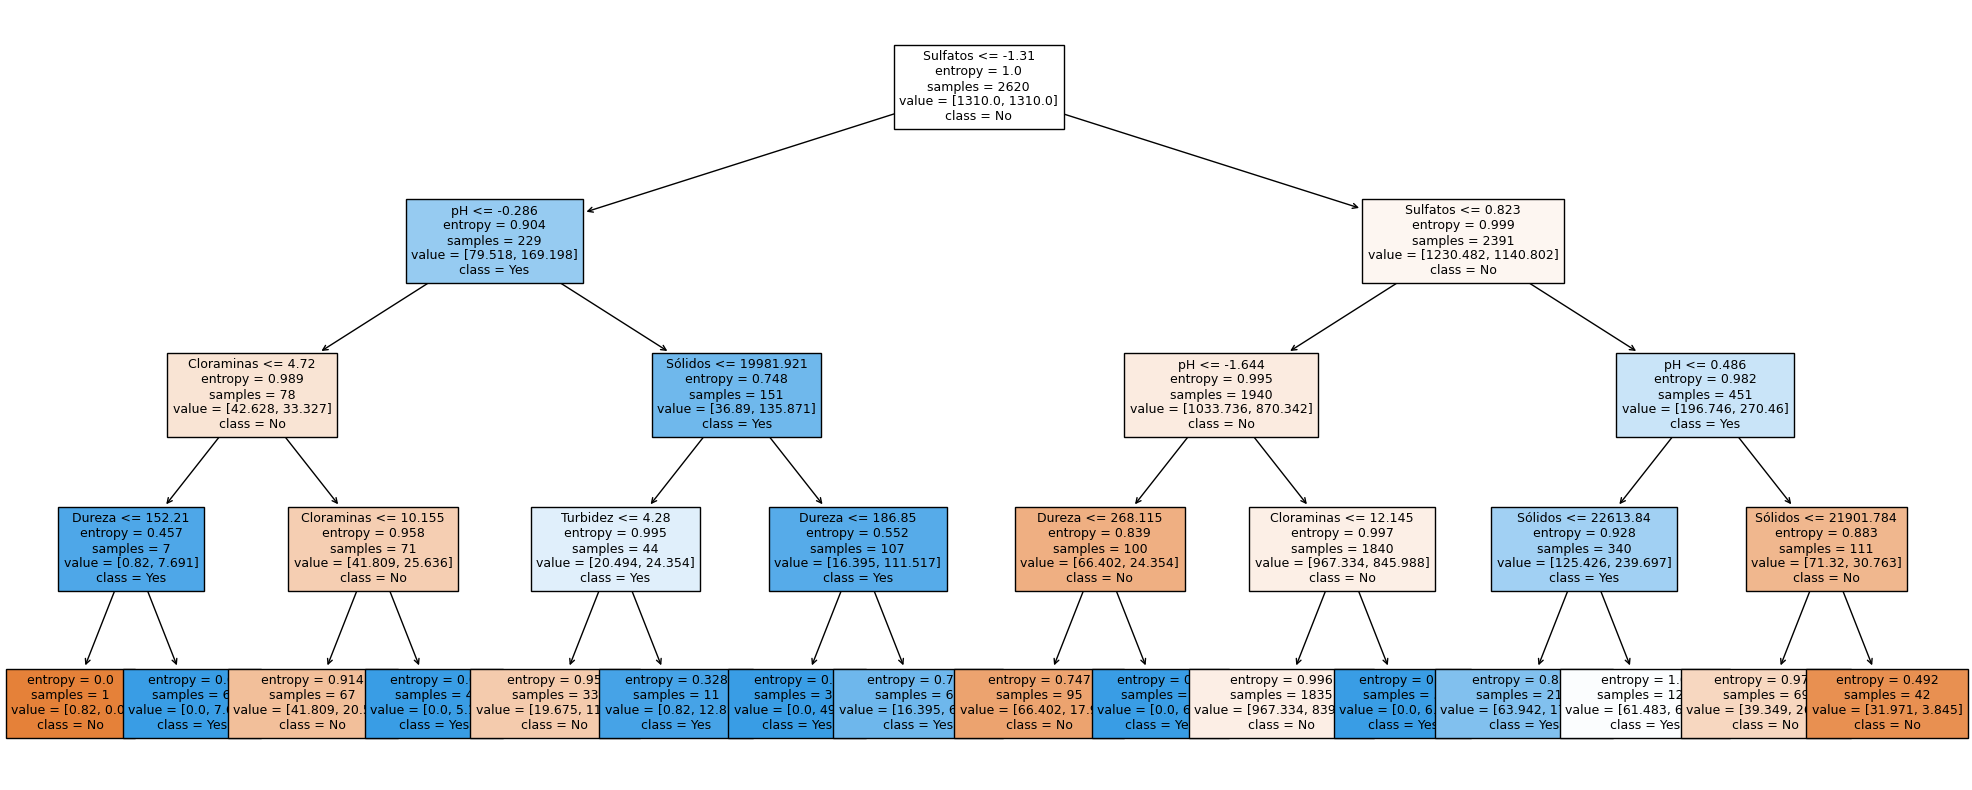

In [61]:
plt.figure(figsize=(25,10))
tree = plot_tree(mejor_modelo, feature_names=x_train.columns, class_names=['No','Yes'], filled=True, fontsize=9)

#### Evaluación del mejor modelo
Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [64]:
x_test = test.drop(['Potabilidad'],axis=1)
y_test = test['Potabilidad']

Incluso con los pasos de preprocesamiento integrados a nuestro modelo, podemos realizar predicciones sobre el conjunto de pruebas directamente mediante la función predict():

In [67]:
y_pred_tree = mejor_modelo.predict(x_test) 

Ahora utilizaremos la función plot_confusion_matrix() para generar un mapa de calor con los valores de la matriz de confusión:

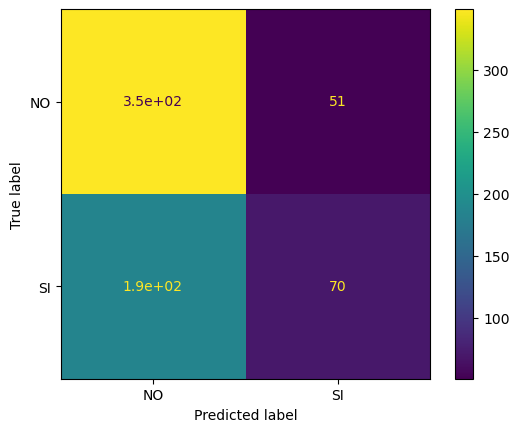

In [70]:
plot_confusion_matrix(mejor_modelo, x_test, y_test)

Como podemos observar, el modelo tiende a predecir correctamente la clase NO, es decir, tiene mejor desempeño al predecir el Agua que no es Potable, mientras que que para la clase SI, es menos efectivo. Podemos observar las métricas de desempeño usando classification_report():

In [73]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

          NO       0.65      0.87      0.75       400
          SI       0.58      0.27      0.37       256

    accuracy                           0.64       656
   macro avg       0.62      0.57      0.56       656
weighted avg       0.62      0.64      0.60       656



Se tiene una precion del 65% para la clase "NO", mientras que para la clase "SI" unicamente acerto un 58%. Recall,
Clase "NO": 0.87 → De todas las veces que el agua era realmente "NO", el modelo lo identificó correctamente el 87% de las veces, mientras que para la Clase "SI": 0.27 → De todas las veces que el agua era realmente "SI", el modelo lo identificó correctamente solo el 27% de las veces.

F1-Score: Clase "NO": 0.75 → El modelo tiene un buen rendimiento para la clase "NO".
Clase "SI": 0.37 → El rendimiento para la clase "SI" es bastante bajo, indicando que el modelo tiene dificultades en predecir agua apta para el consumo

Support: Clase "NO": 400 ejemplos en el conjunto de datos eran "NO" (agua no apta).
Clase "SI": 256 ejemplos eran "SI" (agua apta).
Esto podría indicar un desbalance de clases, que puede estar afectando el rendimiento del modelo para la clase "SI".

Accuracy: 0.64 → El modelo tiene una precisión del 64% en general, lo que significa que acertó en el 64% de todas las predicciones.

El modelo está funcionando relativamente bien para predecir agua no apta ("NO"), pero tiene dificultades importantes para predecir agua apta ("SI"). Dado que el recall para la clase "SI" es bajo (0.27), se están cometiendo muchos errores al identificar correctamente el agua apta, lo que puede ser preocupante en un contexto real de gestión de la calidad del agua.

##### Extraccion de reglas:

Vamos a generar las reglas que nos permiten determinar cuándo el agua no es apta para el consumo,  con una profundidad de tres.

|--- Sulfatos <= -1.31
|   |--- pH <= -0.29
|   |   |--- Cloraminas <= 4.72
|   |   |   |--- class: SI
|   |   |--- Cloraminas >  4.72
|   |   |   |--- class: NO
|   |--- pH >  -0.29
|   |   |--- Sólidos <= 12586.88
|   |   |   |--- class: NO
|   |   |--- Sólidos >  12586.88
|   |   |   |--- class: SI
|--- Sulfatos >  -1.31
|   |--- Sulfatos <= 0.82
|   |   |--- pH <= -1.64
|   |   |   |--- class: NO
|   |   |--- pH >  -1.64
|   |   |   |--- class: NO
|   |--- Sulfatos >  0.82
|   |   |--- pH <= 0.49
|   |   |   |--- class: SI
|   |   |--- pH >  0.49
|   |   |   |--- class: NO



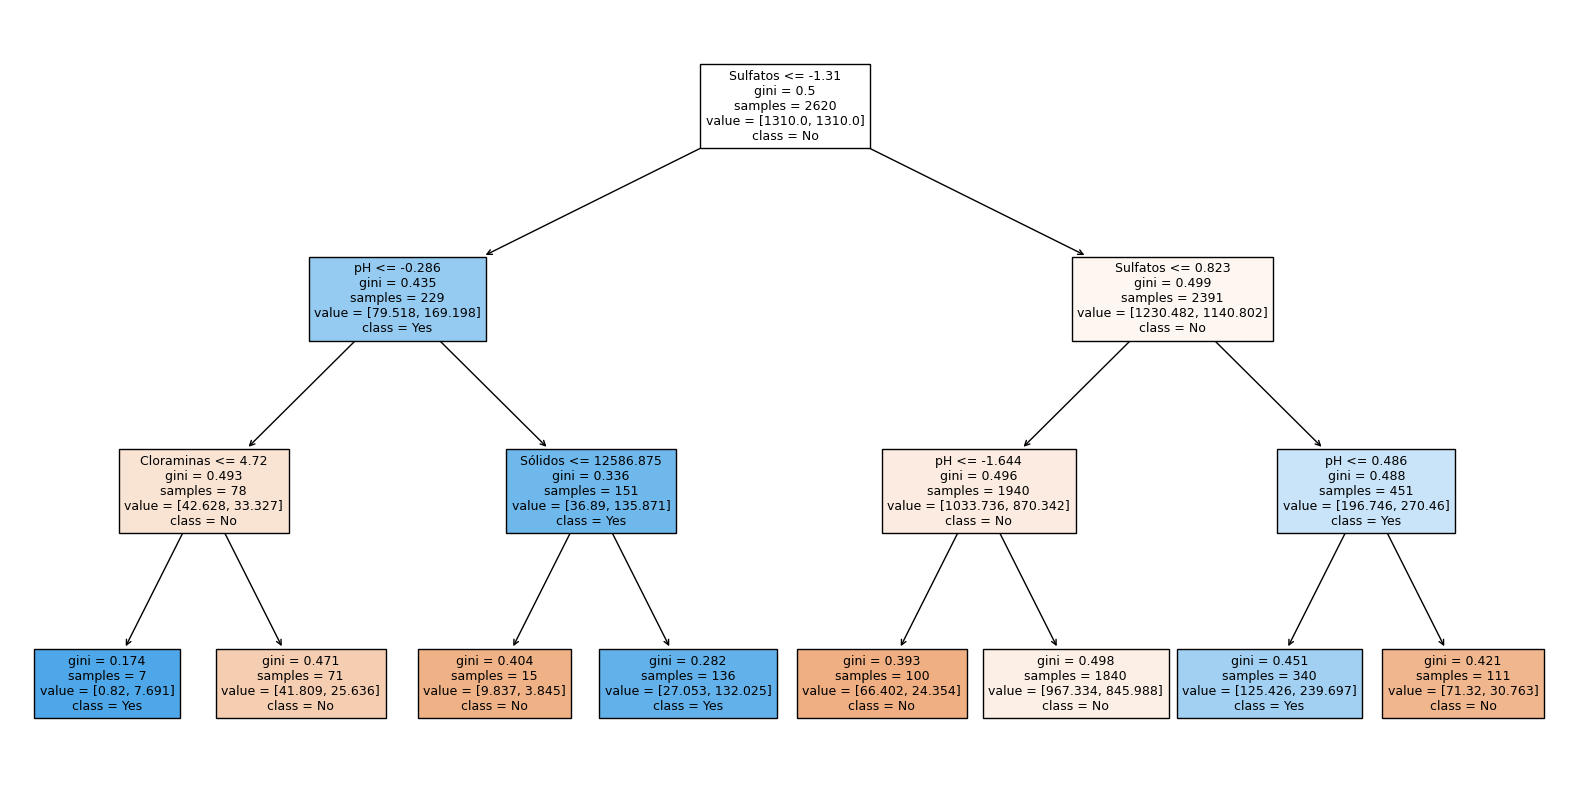

In [77]:
# Crear modelo de árbol de decisión con profundidad 3
decision_tree_rules = DecisionTreeClassifier(max_depth=3, random_state=77, class_weight='balanced')
decision_tree_rules.fit(x_train, y_train)

# Visualizar el árbol de decisión con profundidad 3
plt.figure(figsize=(20,10))
tree = plot_tree(decision_tree_rules, feature_names=x_train.columns, class_names=['No', 'Yes'], filled=True, fontsize=9)

# Extraer reglas
tree_rules = export_text(decision_tree_rules, feature_names=list(x_train.columns))
print(tree_rules)

De las reglas extraídas, podemos hacer las siguientes deducciones acerca de los factores que influyen en que el agua sea o no apta para el consumo:

Sulfatos:

Si el nivel de sulfatos es bajo (≤ -1.31), hay varias condiciones adicionales que determinan si el agua es apta o no.
Si el pH también es bajo (≤ -0.29) y las Cloraminas son bajas (≤ 4.72), el agua no es apta para el consumo (clase: SI).
Si el pH es mayor a -0.29, entonces la cantidad de Sólidos juega un papel importante:
Si los sólidos son bajos (≤ 12586.88), el agua es apta (clase: NO).
Si los sólidos son altos, el agua no es apta (clase: SI).

Sulfatos altos (> -1.31):

Si los sulfatos están entre -1.31 y 0.82, el pH es determinante. Si el pH es muy bajo (≤ -1.64), el agua es apta (clase: NO), de lo contrario también lo es.
Sin embargo, si los sulfatos son mayores a 0.82, el pH vuelve a ser crucial:
Si el pH es bajo (≤ 0.49), el agua no es apta (clase: SI).
Si el pH es más alto, el agua es apta para el consumo (clase: NO).


Las reglas muestran que los Sulfatos, pH, Cloraminas, y la cantidad de Sólidos son los principales factores que influyen en la decisión de si el agua es apta o no.

En general, bajos niveles de Sulfatos y pH tienden a correlacionarse con agua no apta para el consumo.

También es importante el nivel de Sólidos: mayores cantidades de sólidos parecen indicar que el agua es menos apta.

Este conocimiento puede ayudar a enfocar esfuerzos de monitoreo en estos parámetros clave para evitar la contaminación o asegurarse de que el agua cumpla con estándares seguros.

#### Modelo 2: K-Vecinos más Cercanos (KNN)

KNN calcula distancias entre puntos, por lo que realizaremos una estandarización para que la escala de una variable no tenga influencia sobre la clasificación. Utilizaremos un objeto de la clase StandardScaler() que, por cada variable, elimina la media y la escala hasta llegar a una varianza unitaria:

In [82]:
columns = x_train.columns
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train, columns=columns)

x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test, columns=columns)



Determinamos el número óptimo de vecinos para el clasificador KNN.

In [85]:
param_grid_knn = {'n_neighbors': [1, 2, 3, 4, 5]}

#### Búsqueda de Hiperparámetros
Encontramos el mejor valor de 'n_neighbors' que optimice el rendimiento del modelo KNN mediante validación cruzada.

In [88]:
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid_knn, cv=10, n_jobs=-1)
grid_knn.fit(x_train_scaled, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Evaluamos el rendimiento del mejor modelo KNN encontrado mediante GridSearchCV en el conjunto de pruebas:

In [91]:
mejor_knn = grid_knn.best_estimator_
y_pred_knn = mejor_knn.predict(x_test_scaled)

print(f"Mejor valor de K: {grid_knn.best_params_['n_neighbors']}")


Mejor valor de K: 4


In [93]:
print(f"Reporte de clasificación (KNN): \n{classification_report(y_test, y_pred_knn)}")

Reporte de clasificación (KNN): 
              precision    recall  f1-score   support

          NO       0.61      0.82      0.70       400
          SI       0.39      0.18      0.25       256

    accuracy                           0.57       656
   macro avg       0.50      0.50      0.47       656
weighted avg       0.52      0.57      0.52       656



Se obtiene una precisión del 61% de las veces que el modelo predice "NO", la predicción es correcta, mientras que el modelo para la clase "SI" parece que predice unicamente el 39% a nivel de precision.

Por otro lado el recall para la clase "NO" el modelo identifica el 82% de las veces la clase "NO", pero para la clase "SI" detecta un 18% de las veces la clase correctamente

Por el lado del f1-score es una medida que balancea precisión y recall, y para "NO", tienes un valor razonablemente bueno 0.70, pero para la clase "SI" tiene un resultado de 0.25, esto indica que la capacidad del modelo para capturar instancias de la clase "SI" es baja.

Accuracy: 0.57. El modelo está acertando en el 57% de los casos, mayormente para la clase NO.

El modelo está sesgado hacia la clase "NO", ya que predice muy bien esa clase, pero muy pocas veces predice correctamente la clase "SI". Esto podría deberse a un desbalance en los datos (si hay más ejemplos de "NO" que de "SI"), o a que el modelo KNN no está capturando bien las características que diferencian las dos clases.


Ahora, vamos a generar la matriz de confusion:

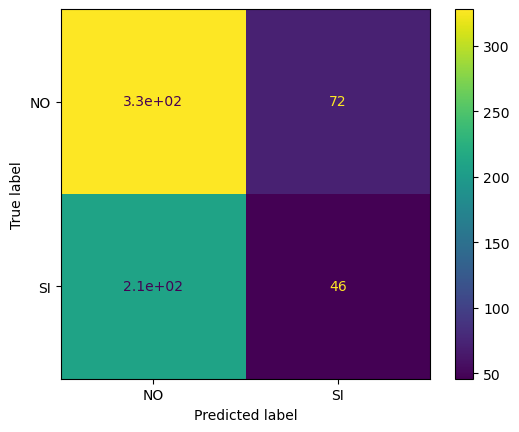

In [97]:
plot_confusion_matrix(mejor_knn, x_test_scaled, y_test)

plt.show()

Analizando la matriz de confusion, se puede deducir:

Clase "NO" mejor representada: El modelo es bastante bueno para identificar la clase "NO" (330 correctas frente a solo 72 incorrectas), lo cual concuerda con los valores de precisión y recall más altos que hemos visto para esta clase.

Problemas con la clase "SI": El modelo tiene dificultades para predecir la clase "SI" correctamente. Con 210 falsos negativos y solo 46 verdaderos positivos, queda claro que la clase "SI" no está siendo detectada adecuadamente. Esto también refleja el bajo valor de recall para "SI" en el reporte de clasificación anterior (18%).

#### Tabla comparativa

A continuacion, construimos una tabla comparativa de los dos modelos para analizar en paralelo:

In [101]:
metrics = {
    'Modelo': ['Árbol de Decisión', 'K-Vecinos Más Cercanos'],
    'Exactitud': [accuracy_score(y_test, y_pred_tree), accuracy_score(y_test, y_pred_knn)],
    'Precisión': [precision_score(y_test, y_pred_tree, average='weighted'), precision_score(y_test, y_pred_knn, average='weighted')],
    'Recall': [recall_score(y_test, y_pred_tree, average='weighted'), recall_score(y_test, y_pred_knn, average='weighted')],
    'F-Score': [f1_score(y_test, y_pred_tree, average='weighted'), f1_score(y_test, y_pred_knn, average='weighted')]
}

In [103]:
resultados_df = pd.DataFrame(metrics)
print(resultados_df)

                   Modelo  Exactitud  Precisión    Recall   F-Score
0       Árbol de Decisión   0.638720   0.623527  0.638720  0.600116
1  K-Vecinos Más Cercanos   0.570122   0.523876  0.570122  0.522435


Analicemos la tabla comparativa:

##### ¿Qué puedes decir de los valores de las métricas recall y precisión para cada una de las clases en cada modelo? ¿Cuál de estás métricas consideras que es más importante con base en la descripción del problema?

Exactitud:

Árbol de Decisión: 63.87% ---
K-Vecinos Más Cercanos: 57.01%

El Árbol de Decisión tiene una exactitud más alta, lo que indica que predice correctamente un mayor número de instancias en comparación con KNN.

Precisión:

Árbol de Decisión: 62.35% ---
K-Vecinos Más Cercanos: 52.39%

La precisión del Árbol de Decisión es superior. Esto significa que, de las predicciones positivas que realiza, un mayor porcentaje son correctas en comparación con el modelo de KNN.

Recall:

Árbol de Decisión: 63.87% ---
K-Vecinos Más Cercanos: 57.01%

El Árbol de Decisión también tiene un mejor recall, lo que indica que identifica mejor los casos verdaderamente positivos. Es decir, de todos los ejemplos que pertenecen a una clase, el Árbol de Decisión encuentra un mayor número que KNN.

F-Score:

Árbol de Decisión: 60.01% ---
K-Vecinos Más Cercanos: 52.24%

El F-Score del Árbol de Decisión es más alto, lo que indica un mejor equilibrio entre precisión y recall. El F-Score es especialmente útil cuando las clases están desbalanceadas o cuando una métrica no puede evaluarse en aislamiento.

Conclusion:

El Árbol de Decisión supera al modelo de K-Vecinos Más Cercanos (KNN) en todas las métricas principales: exactitud, precisión, recall y F-Score. Esto sugiere que, en este caso, el Árbol de Decisión es el modelo más preciso y adecuado.

Además, dado que el Árbol de Decisión tiene un F-Score más alto, es probable que maneje mejor el balance entre las predicciones correctas y la captura de las clases positivas, lo que lo convierte en una opción más robusta.


##### ¿Consideras que el rendimiento de los modelos es adecuado? Si no es así, ¿Cómo podrían mejorarse los resultados?

Se puede observar que ambos modelos tienen un rendimiento moderado, pero no óptimo. Algunas métricas como la exactitud y el F-score están por debajo del 70%, lo cual indica que todavía hay margen de mejora en la capacidad de los modelos para hacer predicciones correctas, si bien el Árbol de Decisión tiene un mejor rendimiento que el KNN, ninguna de las métricas supera un valor excelente, como un F-score cercano al 1 o una exactitud superior al 80%.

Considero que el rendimiento es inadecuado, la presion no es suficiente, considero que una gran ayuda para mejorar el modelo es balancear las clases, por lo que en este momento estan desbalanceadas, quizas probar algunos otros modelos, o considerar variables mas afinadas.


#### Si los dos modelos proporcionan resultados similares en cuanto a las métricas de rendimiento ¿Cuál seleccionarías tomando en cuenta el contexto del problema?

Aunque los dos modelos son relativamente similares, el modelo de Árbol de Decisión tiene mayor solides, adicional que para el tipo de problema siempre seleccionaria el Arbol de decisiones.

Los árboles de decisión son fáciles de interpretar y visualizar. Dado que en este caso se han identificado las variables más importantes (pH, Sulfatos, Sólidos, etc.), este modelo permite una comprensión clara de cómo las variables influyen en la clasificación. En la gestión de calidad del agua, donde podría haber variabilidad en los datos de diferentes cuerpos de agua, un modelo más robusto, como el árbol de decisión, genera resultados más confiables. La razón es que los árboles de decisión no solo ofrecen predicciones, sino que también proporcionan una interpretación clara y fácil de entender de las variables que más influyen en la calidad del agua.

